### Data Import and Setup
Import necessary libraries for building and training a neural network, including NumPy for numerical computations, 
Matplotlib for visualization, and scikit-learn for dataset handling and preprocessing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from PIL import Image

### MNIST Dataset Loading
Define a function to load and preprocess the MNIST dataset. The function:
- Loads the MNIST dataset using fetch_openml
- Normalizes pixel values to [0,1]
- One-hot encodes the labels
- Returns processed features and labels

In [2]:
# Load the MNIST dataset
def load_mnist():
    mnist = fetch_openml('mnist_784', version=1)
    X, y = mnist.data.astype(np.float32), mnist.target.astype(np.int32)
    
    # Normalize the data
    X /= 255.0
    
    # Convert y to a NumPy array and reshape it for one-hot encoding
    y = np.array(y).reshape(-1, 1)
    
    # One-hot encode the labels
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(y)
    
    return X, y

# Load and split the data
X, y = load_mnist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Neural Network Architecture
Define the neural network class with configurable layer sizes.
Initialize weights using He initialization for better training dynamics.

In [3]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.layers = len(hidden_sizes) + 1
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases for each layer
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            self.weights.append(np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2 / sizes[i]))
            self.biases.append(np.zeros((1, sizes[i+1])))


### Activation Functions
Define the necessary activation functions and their derivatives:
- ReLU for hidden layers
- Softmax for output layer

In [4]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### Forward Propagation with Dropout
Implement forward propagation with dropout regularization to prevent overfitting.
Dropout randomly deactivates neurons during training with a specified probability.

In [5]:
# Apply dropout to the activations
def apply_dropout(activations, dropout_rate):
    mask = np.random.binomial(1, 1 - dropout_rate, size=activations.shape)
    return activations * mask / (1 - dropout_rate)

# Modify the forward_propagation method to include dropout
def forward_propagation_with_dropout(self, X, dropout_rate=0.0):
    activations = [X]
    z_values = []
    
    for i, (w, b) in enumerate(zip(self.weights, self.biases)):
        z = np.dot(activations[-1], w) + b
        z_values.append(z)
        
        # Apply ReLU for hidden layers, softmax for the output layer
        if i < self.layers - 1:
            activation = relu(z)
            if dropout_rate > 0:  # Apply dropout only during training
                activation = apply_dropout(activation, dropout_rate)
        else:
            activation = softmax(z)
        
        activations.append(activation)
    
    return activations, z_values

NeuralNetwork.forward_propagation = forward_propagation_with_dropout

### Back Propagation
Implement the backpropagation algorithm to compute gradients for network parameters.
Uses the chain rule to propagate errors backward through the network.

In [6]:
def back_propagation(self, activations, z_values, y_true):
    deltas = [activations[-1] - y_true]
    
    for i in reversed(range(self.layers - 1)):
        delta = np.dot(deltas[0], self.weights[i + 1].T) * relu_derivative(z_values[i])
        deltas.insert(0, delta)
    
    # Compute gradients for weights and biases
    grad_w = []
    grad_b = []
    for i in range(self.layers):
        grad_w.append(np.dot(activations[i].T, deltas[i]) / y_true.shape[0])
        grad_b.append(np.sum(deltas[i], axis=0, keepdims=True) / y_true.shape[0])
    
    return grad_w, grad_b

NeuralNetwork.back_propagation = back_propagation


### Parameter Updates with L2 Regularization
Update network parameters using gradient descent with L2 regularization to prevent overfitting.

In [7]:
def update_parameters_with_l2(self, grad_w, grad_b, learning_rate, l2_lambda):
    for i in range(self.layers):
        self.weights[i] -= learning_rate * (grad_w[i] + l2_lambda * self.weights[i])
        self.biases[i] -= learning_rate * grad_b[i]

NeuralNetwork.update_parameters = update_parameters_with_l2

### Training Loop
Implement the main training loop with:
- Mini-batch gradient descent
- Loss and accuracy tracking
- Progress visualization

In [8]:
# Modify train method to store loss and accuracy
def train(self, X, y, epochs, batch_size, learning_rate, l2_lambda=0.0, dropout_rate=0.0):
    X = np.array(X)
    y = np.array(y)
    
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]
        
        epoch_loss = 0
        for start in range(0, X.shape[0], batch_size):
            end = start + batch_size
            batch_X, batch_y = X[start:end], y[start:end]
            
            # Forward and backward pass
            activations, z_values = self.forward_propagation(batch_X, dropout_rate=dropout_rate)
            grad_w, grad_b = self.back_propagation(activations, z_values, batch_y)
            
            # Update parameters with L2 regularization
            self.update_parameters(grad_w, grad_b, learning_rate, l2_lambda)
            
            # Compute loss
            batch_loss = -np.mean(np.sum(batch_y * np.log(activations[-1]), axis=1))
            epoch_loss += batch_loss
        
        # Calculate accuracy for monitoring
        epoch_loss /= (X.shape[0] // batch_size)
        epoch_accuracy = self.accuracy(X, y)
        losses.append(epoch_loss)
        accuracies.append(epoch_accuracy)
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    # Plot the training loss and accuracy
    plt.figure()
    plt.plot(range(epochs), losses, label='Loss')
    plt.plot(range(epochs), accuracies, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Training Loss and Accuracy')
    plt.show()

NeuralNetwork.train = train


### Prediction and Accuracy Methods
Define methods for making predictions and calculating model accuracy

In [9]:
def predict(self, X):
    activations, _ = self.forward_propagation(X)
    return np.argmax(activations[-1], axis=1)

def accuracy(self, X, y_true):
    y_pred = self.predict(X)
    y_true = np.argmax(y_true, axis=1)
    return np.mean(y_pred == y_true)

NeuralNetwork.predict = predict
NeuralNetwork.accuracy = accuracy

### Model Training
Create and train the neural network with:
- 784 input features (28x28 pixels)
- Two hidden layers (128 and 64 neurons)
- 10 output classes (digits 0-9)

Epoch 1/50, Loss: 0.6098, Accuracy: 0.9066
Epoch 2/50, Loss: 0.4170, Accuracy: 0.9105
Epoch 3/50, Loss: 0.3871, Accuracy: 0.9192
Epoch 4/50, Loss: 0.3689, Accuracy: 0.9198
Epoch 5/50, Loss: 0.3551, Accuracy: 0.9289
Epoch 6/50, Loss: 0.3474, Accuracy: 0.9242
Epoch 7/50, Loss: 0.3449, Accuracy: 0.9185
Epoch 8/50, Loss: 0.3398, Accuracy: 0.9263
Epoch 9/50, Loss: 0.3349, Accuracy: 0.9332
Epoch 10/50, Loss: 0.3317, Accuracy: 0.9313
Epoch 11/50, Loss: 0.3310, Accuracy: 0.9239
Epoch 12/50, Loss: 0.3257, Accuracy: 0.9289
Epoch 13/50, Loss: 0.3294, Accuracy: 0.9329
Epoch 14/50, Loss: 0.3250, Accuracy: 0.9318
Epoch 15/50, Loss: 0.3260, Accuracy: 0.9346
Epoch 16/50, Loss: 0.3266, Accuracy: 0.9376
Epoch 17/50, Loss: 0.3246, Accuracy: 0.9297
Epoch 18/50, Loss: 0.3258, Accuracy: 0.9371
Epoch 19/50, Loss: 0.3200, Accuracy: 0.9305
Epoch 20/50, Loss: 0.3190, Accuracy: 0.9347
Epoch 21/50, Loss: 0.3206, Accuracy: 0.9317
Epoch 22/50, Loss: 0.3224, Accuracy: 0.9270
Epoch 23/50, Loss: 0.3189, Accuracy: 0.92

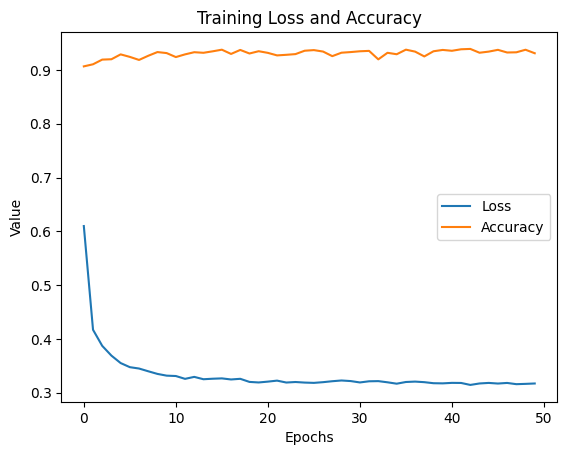

Test Accuracy: 0.9271


In [10]:
# Define the network
nn = NeuralNetwork(input_size=784, hidden_sizes=[128, 64], output_size=10)

# Train the network
nn.train(X_train, y_train, epochs=50, batch_size=64, learning_rate=0.1, dropout_rate=0.2, l2_lambda=0.01)

# Test accuracy
test_accuracy = nn.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


### Model Testing
Test the trained model on random samples from the test set
Visualize results with true and predicted labels

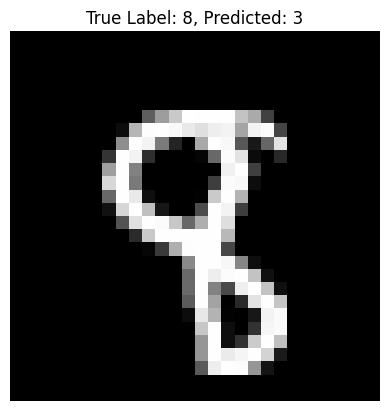

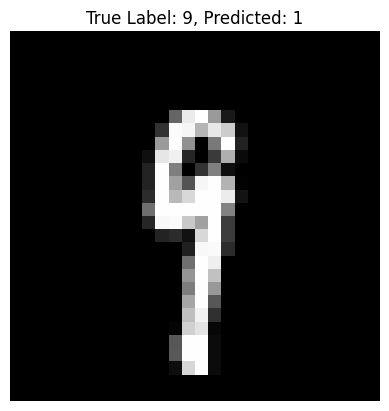

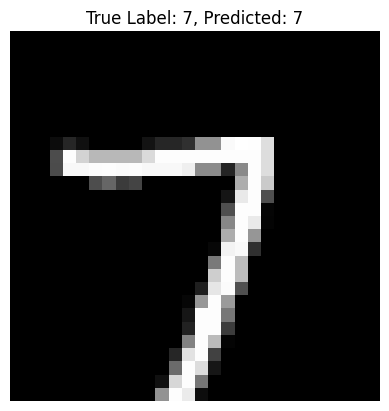

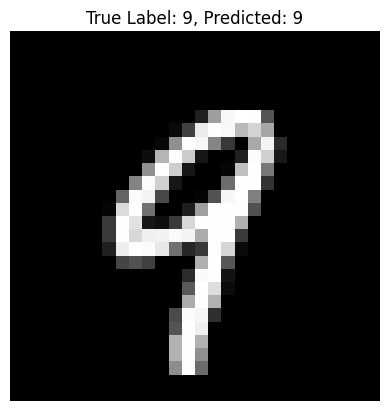

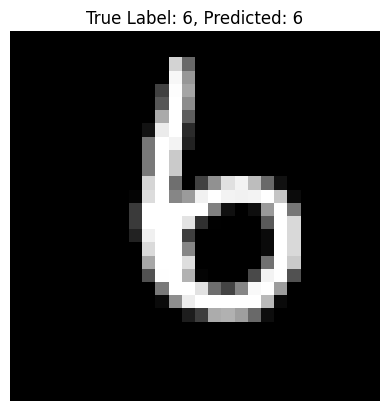

In [12]:
# Function to test the model on random test samples
def test_random_samples(model, X_test, y_test, num_samples=5):
    # Convert X_test to numpy array if it isn't already
    X_test_array = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else np.array(X_test)
    y_test_array = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)
    
    indices = np.random.choice(range(X_test_array.shape[0]), num_samples, replace=False)
    for idx in indices:
        image = X_test_array[idx].reshape(28, 28)
        true_label = np.argmax(y_test_array[idx])
        predicted_label = model.predict(X_test_array[idx:idx+1])[0]
        
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.title(f"True Label: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

# Test the model on random samples
test_random_samples(nn, X_test, y_test, num_samples=5)